# (30) Fit -- cuda2

**Motivation**: Fitting notebook, cuda2 <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [2]:
vae = VAE(ConfigVAE(
    n_kers=8,
    n_pre_blocks=2, n_pre_cells=33,
    n_latent_scales=1, n_groups_per_scale=1, n_latent_per_group=210,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.002, batch_size=500, epochs=2000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-3,
        kl_beta=0.25, kl_anneal_cycles=1, kl_anneal_portion=0.3,
        scheduler_kws={'T_max': 650.0, 'eta_min': 1e-05},
        optimizer='adamax',
    ),
    device='cuda:2',
)
vae.cfg.total_latents()

210

In [3]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.1 Mil  |
|     ---      |    ---     |
|     stem     |   2.2 K    |
| pre_process  |  13.1 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  1.7 Mil   |
|    expand    |  706.0 K   |
| stem_decoder |  860.7 K   |
| post_process |  630.2 K   |
|     out      |   2.3 K    |
+--------------+------------+

[4]

In [4]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(149, 143)

(291, 228)

## Review train options

In [5]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

k-64_z-210x[1]_enc(2x2)-dec(2x1)-pre(2x33)-post(1x3)
ep2000-b500-lr(0.002)_beta(0.25:1x0.3)_lamb(0.001)_gr(1000)

## Train

In [6]:
comment = f"Vanilla_{tr.cfg.name()}"
tr.train(comment=comment)

epoch # 1660, avg loss: nan:  83%|████████▎ | 1659/2000 [28:00:25<5:45:24, 60.77s/it]                                              


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [7]:
%%time

regr = regress(val['z_vld'], val['g_vld'], val['z_tst'], val['g_tst'])
regr_ema = regress(val_ema['z_vld'], val_ema['g_vld'], val_ema['z_tst'], val_ema['g_tst'])

NameError: name 'regress' is not defined

In [41]:
regr['r2'].mean() * 100, regr_ema['r2'].mean() * 100

(76.32313495366438, 76.34126969216219)

In [42]:
np.diag(regr['r']).mean(), np.diag(regr_ema['r']).mean()

(0.8673879424626705, 0.8675133476276031)

In [53]:
do_zscore = True
if do_zscore:
    x = sp_stats.zscore(val_ema['z_vld'])
    y = sp_stats.zscore(val_ema['g_vld'])
    x_tst = sp_stats.zscore(val_ema['z_tst'])
    y_tst = sp_stats.zscore(val_ema['g_tst'])
else:
    x = val_ema['z_vld']
    y = val_ema['g_vld']
    x_tst = val_ema['z_tst']
    y_tst = val_ema['g_tst']

lr = sk_linear.LinearRegression().fit(x, y)
r2_out = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)
r_out = 1 - sp_dist.cdist(
    XA=y_tst.T,
    XB=lr.predict(x_tst).T,
    metric='correlation',
)

r2_out, r2_out.mean(), np.diag(r_out).mean()

(array([0.95625957, 0.95080727, 0.90007567, 0.93476931, 0.97266867,
        0.69844531, 0.71228307, 0.48491498, 0.57753296, 0.52304924,
        0.66261758]),
 0.7612203313626602,
 0.8664831015191742)

In [54]:
list(regr_ema)

['mi', 'mi_norm', 'mig', 'r', 'r2', 'd', 'c']

In [56]:
regr_ema['mig'].mean()

0.043084274384590164

In [60]:
regr_ema['d'], regr_ema['c'], regr_ema['r2'].mean()

(0.20397511, 0.2297739, 0.7634126969216218)

In [163]:
lasso = sk_linear.Lasso(alpha=0.02, max_iter=1e5).fit(x, y)
r2_lasso = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lasso.predict(x_tst),
    multioutput='raw_values',
)
r2_lasso, r2_lasso.mean()

(array([0.94818922, 0.93941325, 0.8679509 , 0.92086765, 0.96823294,
        0.67899278, 0.69742769, 0.45055492, 0.53920662, 0.4847084 ,
        0.55348721]),
 0.731730143531567)

In [164]:
compute_dci(np.abs(lasso.coef_))

(0.7938755, 0.5827414)

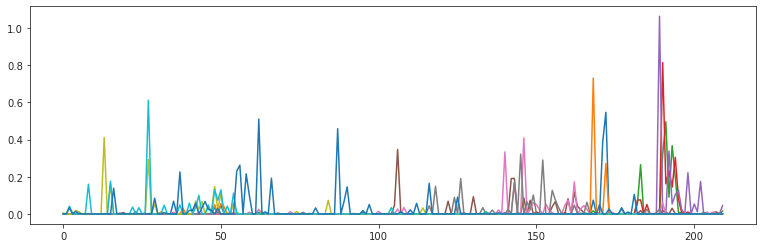

In [165]:
fig, ax = create_figure(1, 1, (13, 4))
plt.plot(np.abs(lasso.coef_).T);

## Eval

In [7]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 25.4 s, sys: 10.7 s, total: 36.1 s
Wall time: 1min 8s


In [8]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b500-lr(0.002)_beta(0.25:1x0.3)_lamb(0.001)_gr(1000)

{'epe': {'vae': 3.54, 'ema': 3.54}, 'kl': {'vae': 31.21, 'ema': 31.17}}

fig/sample (VAE)

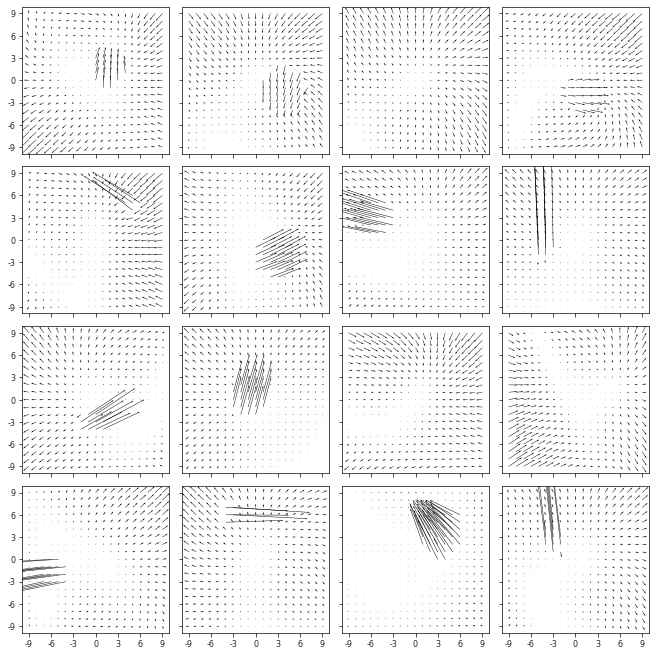

fig/sample (EMA)

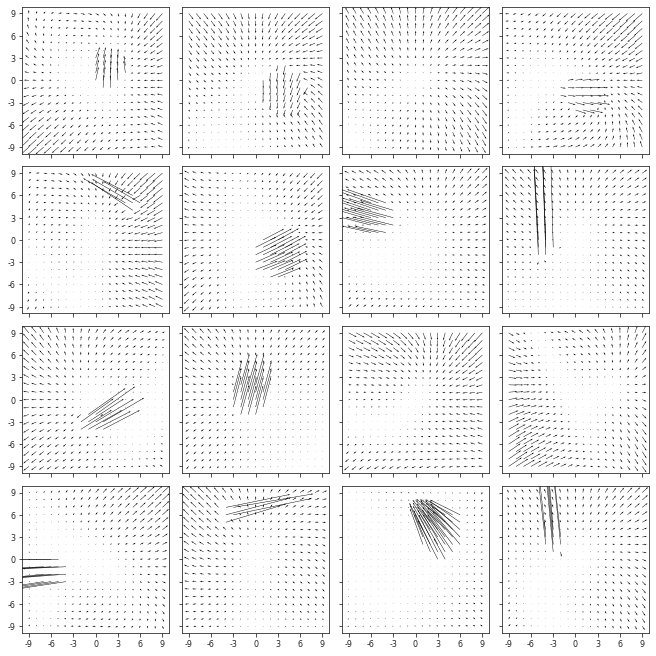

----------------------------------------------------------------------

fig/regression (VAE)

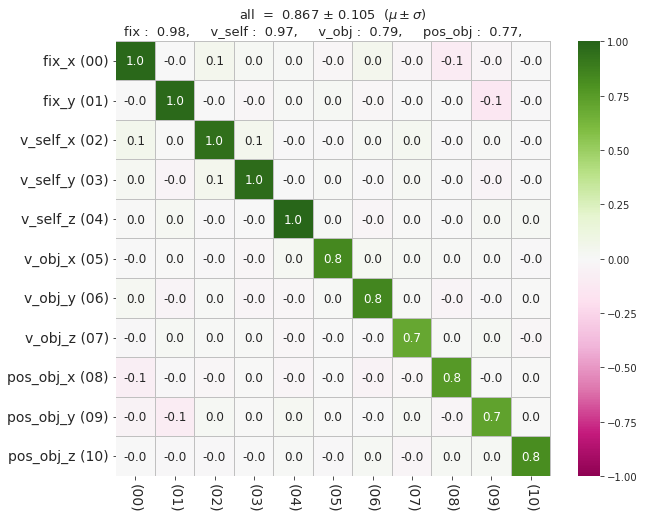

fig/regression (EMA)

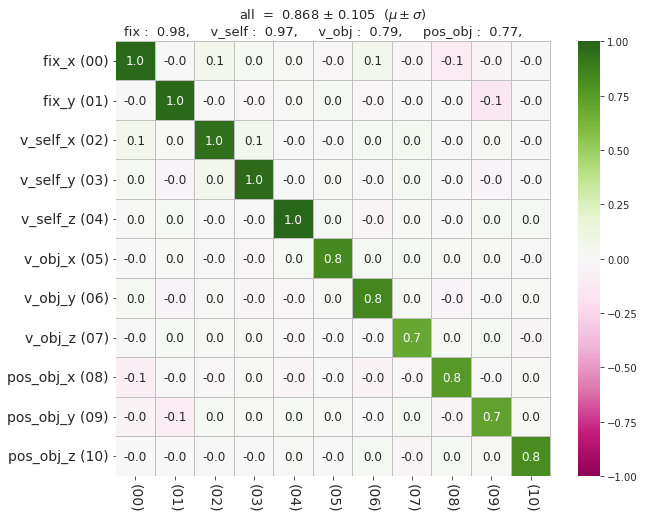

----------------------------------------------------------------------

fig/mutual_info (VAE)

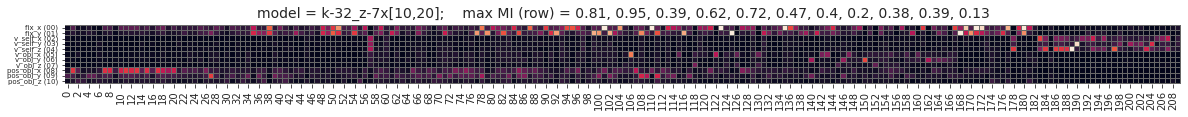

fig/mutual_info (EMA)

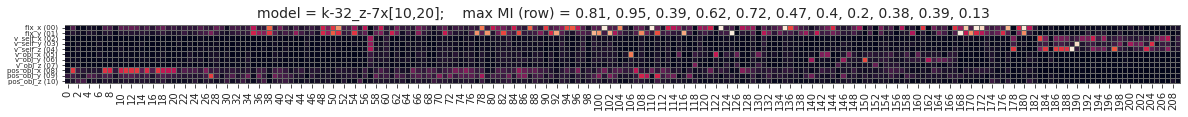

----------------------------------------------------------------------

In [9]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [14]:
len(tr.stats['grad'])

77

In [21]:
np.quantile(tr.stats['grad'], [0.5, 0.7, 0.9, 1])

array([2.08101733e+03, 1.10896814e+04, 2.04761288e+07, 7.40017701e+11])

In [23]:
np.quantile(tr.stats['loss'], [0.5, 0.7, 0.9, 1])

array([1.08627501e+01, 1.16923437e+01, 2.90405513e+03, 1.09240038e+09])

In [24]:
gamma = np.stack(tr.stats['gamma'])
gamma.shape

(160000, 30)

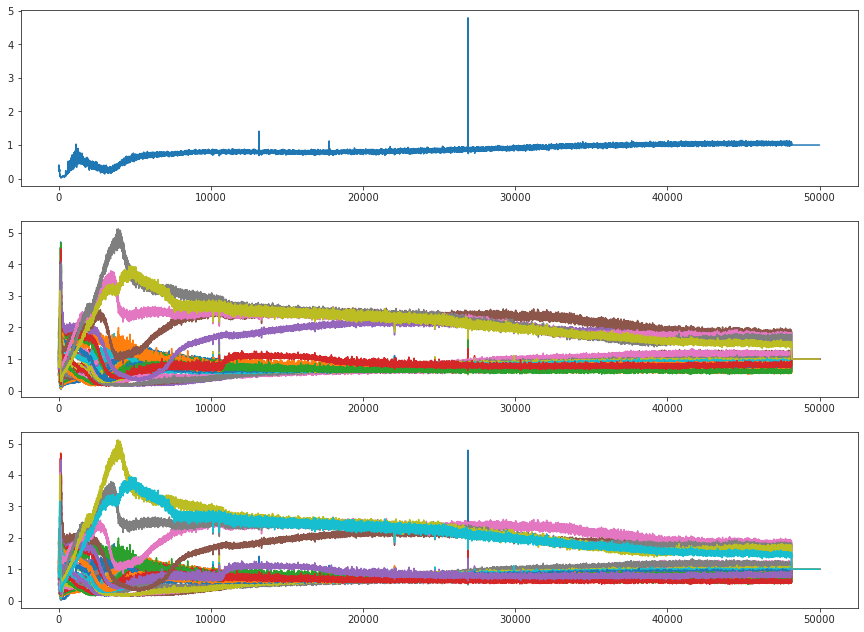

In [25]:
fig, axes = create_figure(3, 1, (15, 11))
axes[0].plot(gamma[:50000, 0])
axes[1].plot(gamma[:50000, 1:])
axes[2].plot(gamma[:50000]);

In [34]:
vae.expand

ModuleList(
  (0-9): 10 x DeConv2D(7, 7, kernel_size=(4, 4), stride=(1, 1))
  (10-29): 20 x DeConv2D(7, 7, kernel_size=(8, 8), stride=(1, 1))
)

## Eval fit (old code)

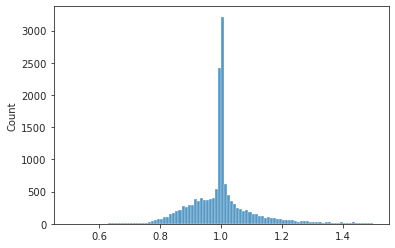

In [26]:
all_norm = [torch.exp(n.ravel()) for n in vae.all_log_norm]
all_norm = to_np(torch.cat(all_norm))
sns.histplot(all_norm, bins=np.linspace(0.5, 1.5, 101));

In [27]:
np.max(all_norm), 100 * (all_norm < 0.5).sum() / len(all_norm), 100 * (all_norm > 1.5).sum() / len(all_norm)

(5.4563937, 0.0, 1.7846191585919293)

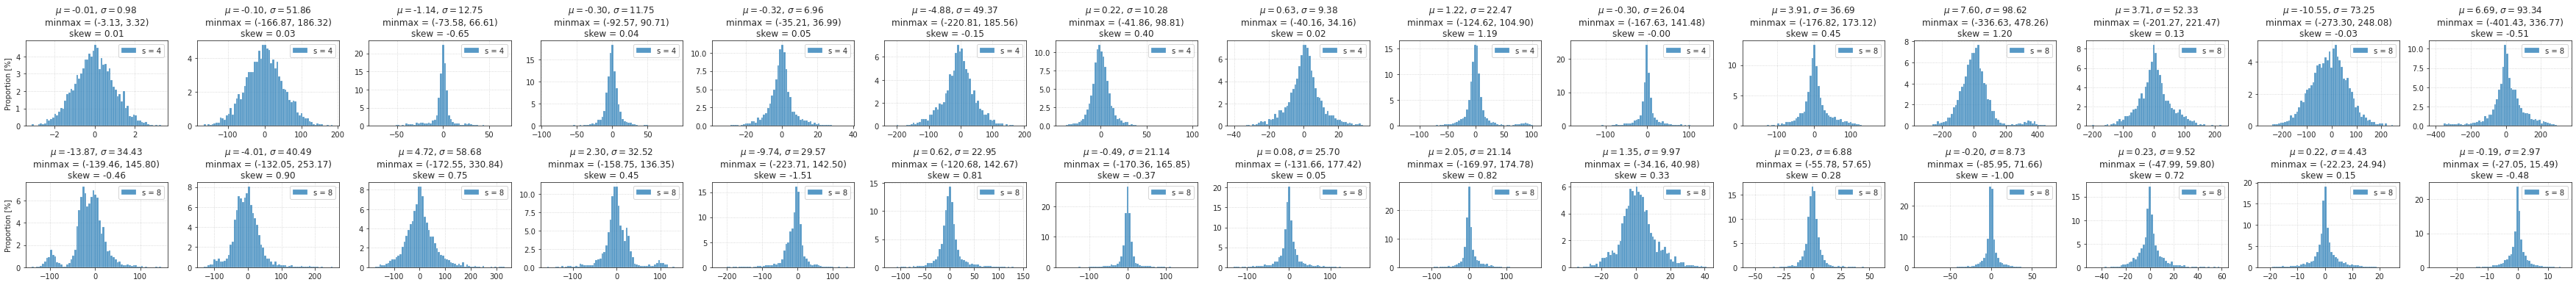

In [28]:
_ = plot_latents_hist(
    z=val['z_sample'],
    scales=vae.latent_scales()[0],
)

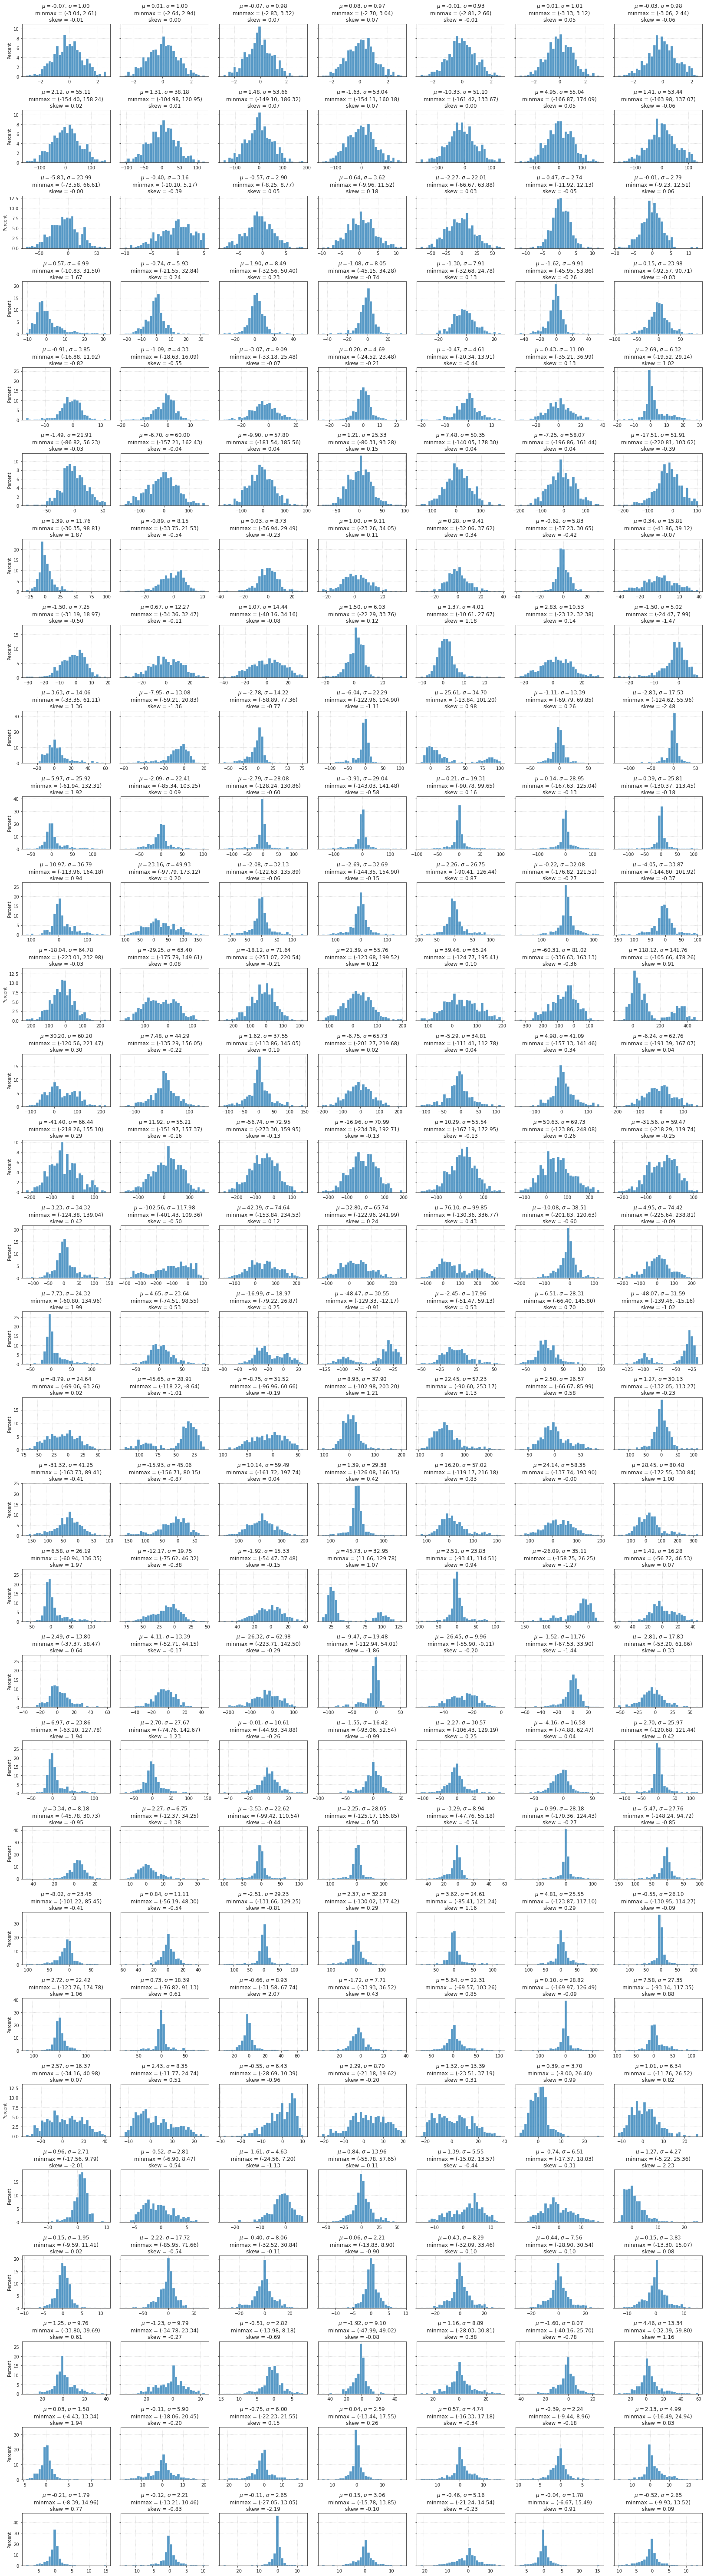

CPU times: user 40.1 s, sys: 1.31 s, total: 41.4 s
Wall time: 41.4 s


In [29]:
%%time

_ = plot_latents_hist_full(
    z=val['z_sample'],
    scales=vae.latent_scales()[0],
    constrained_layout=False,
    tight_layout=True,
)

In [31]:
from vae.vae2d import *

In [32]:
norms = collections.defaultdict(list)
# norms['stem'] = list(to_np(vae.stem.lognorm.exp()))
for cell in vae.enc_tower:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_enc"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.dec_tower:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_dec"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.enc_sampler:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['enc_sampler'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.dec_sampler:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['dec_sampler'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.expand:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['expand'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.pre_process:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_pre"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.post_process:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_post"].extend(
                list(to_np(m.lognorm.exp())))
norms = dict(sorted(norms.items()))

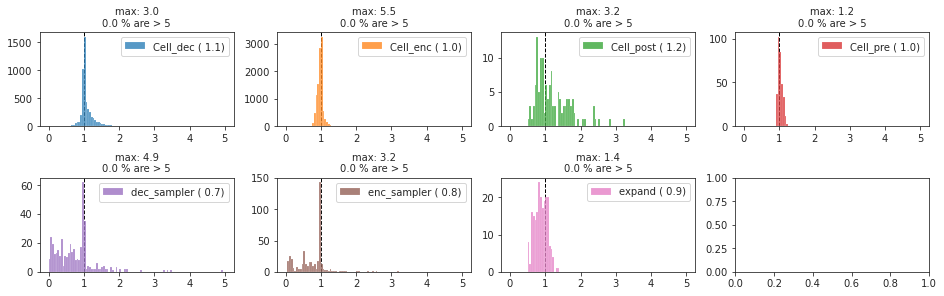

In [33]:
fig, axes = create_figure(2, 4, (13, 4), constrained_layout=True)
for i, (k, v) in enumerate(norms.items()):
    ax = axes.flat[i]
    ax.axvline(1, color='k', ls='--', lw=1.0, zorder=0)
    sns.histplot(v, color=f"C{i}", bins=np.linspace(0, 5, 101), label=f"{k} ({np.mean(v): 0.1f})", ax=ax)
    title = f"max: {np.max(v):0.1f}\n{100 * (np.array(v) > 5).sum() / len(v):0.1f} % are > 5"
    ax.set_title(title, fontsize=10)
    ax.set_ylabel('')
    ax.legend()
plt.show()

In [72]:
x, norm = next(iter(tr.dl_tst))
y, z, q, p = tr.model(x)

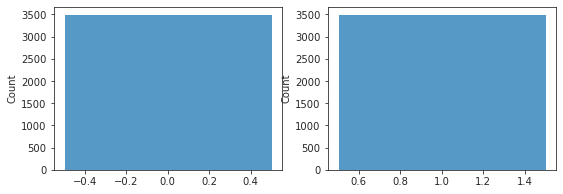

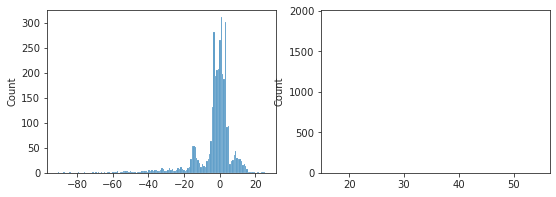

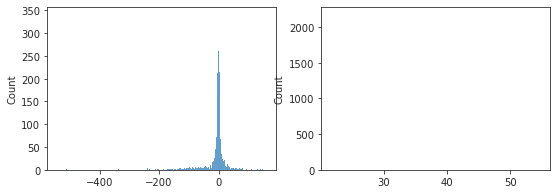

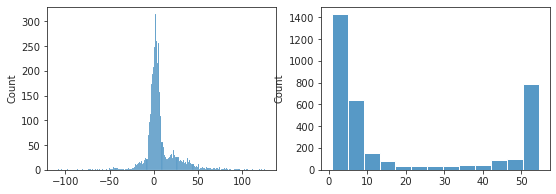

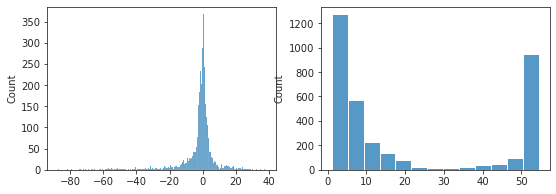

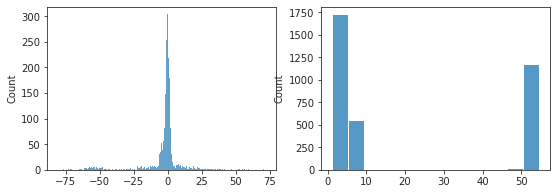

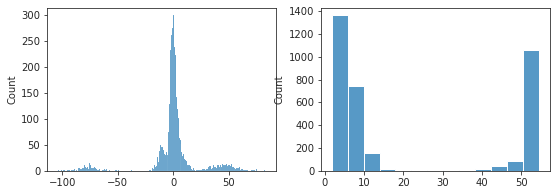

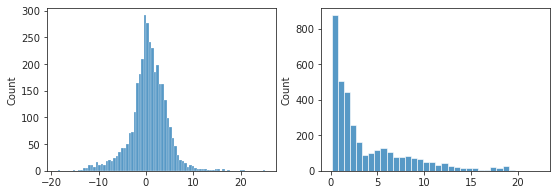

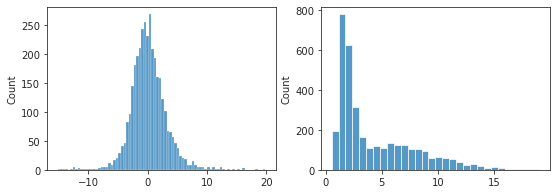

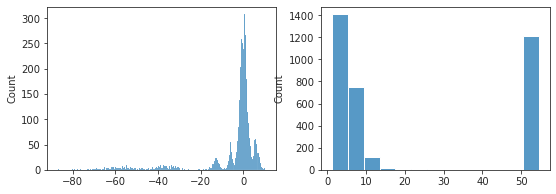

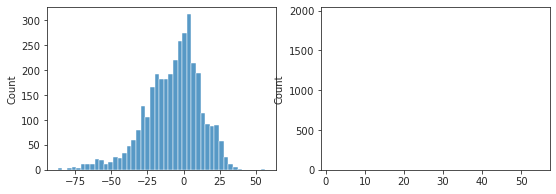

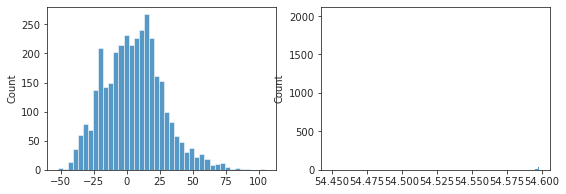

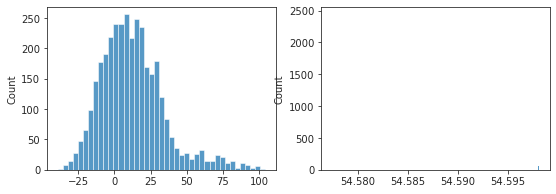

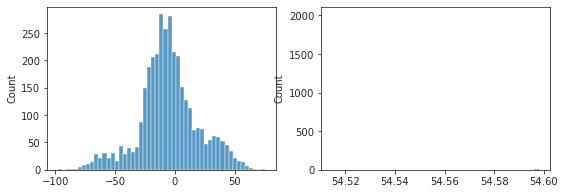

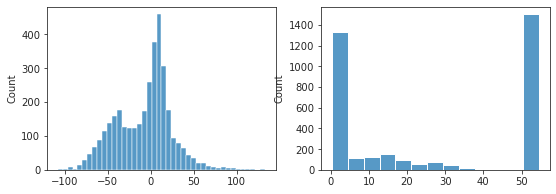

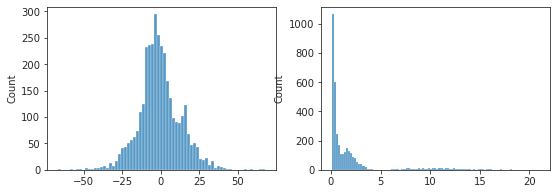

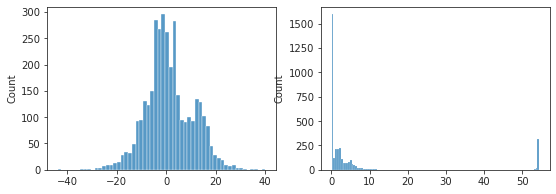

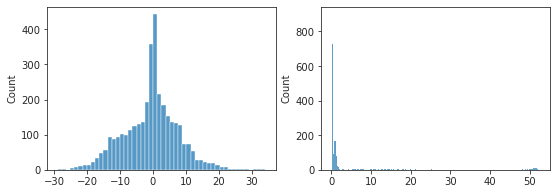

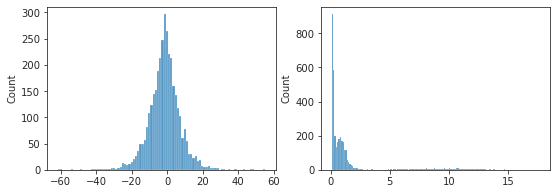

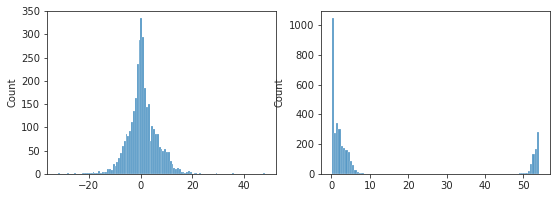

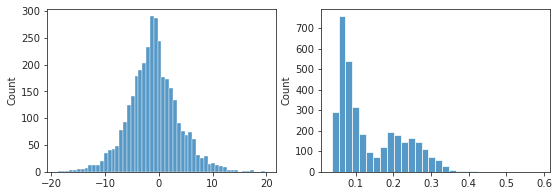

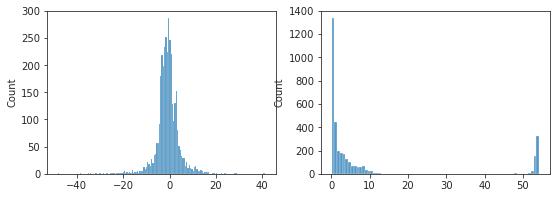

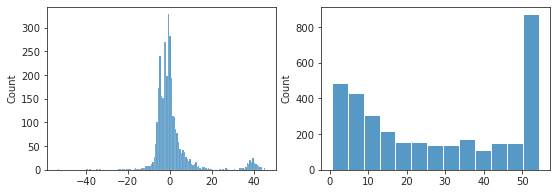

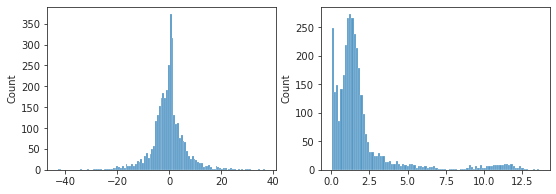

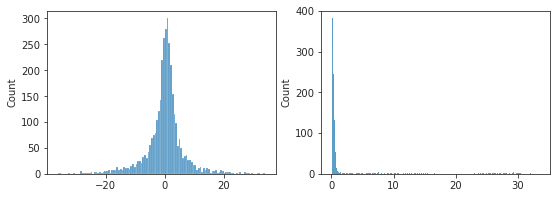

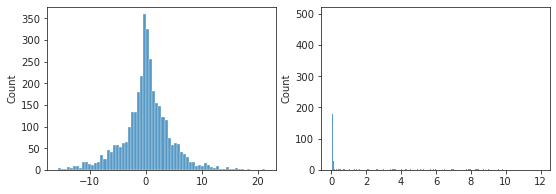

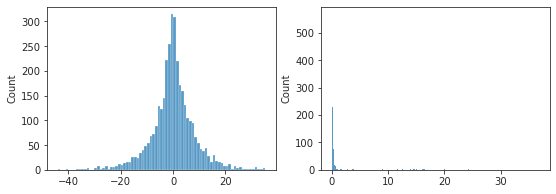

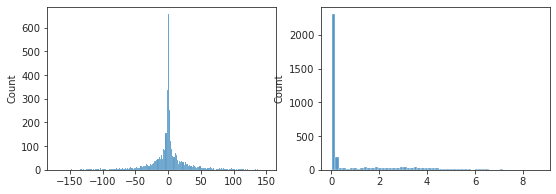

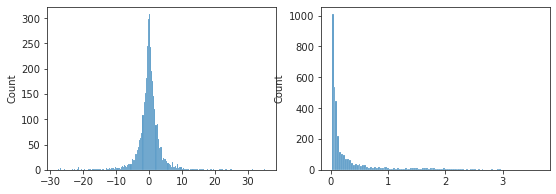

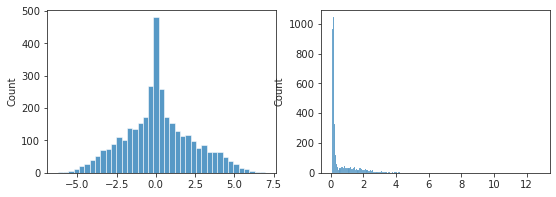

In [84]:
for dist in p:
    fig, axes = create_figure(1, 2, (9, 3))
    sns.histplot(to_np(dist.mu.squeeze().ravel()), ax=axes[0])
    sns.histplot(to_np(dist.sigma.squeeze().ravel()), ax=axes[1])
    plt.show()

## Gradient quantiles

In [12]:
a = np.stack(tr.stats['q'])
a.shape

(3028, 4)

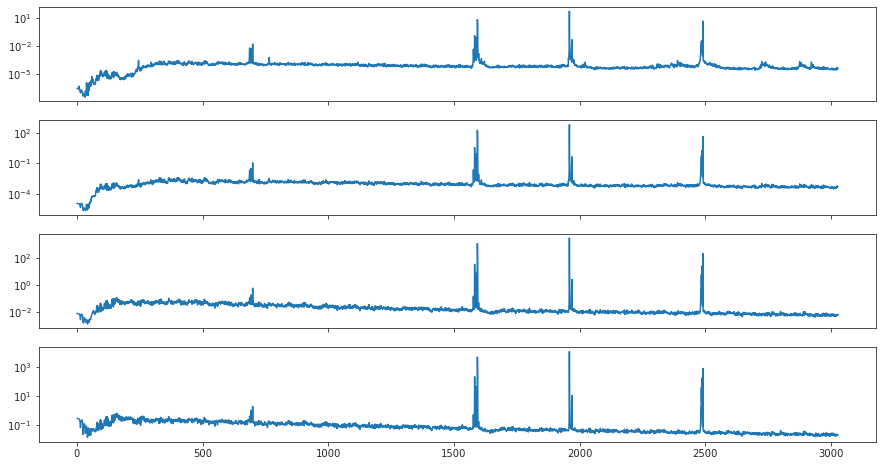

In [21]:
fig, axes = create_figure(4, 1, (15, 8), 'all')
for i, ax in enumerate(axes.flat):
    ax.plot(a[:, i])
    ax.set_yscale('log')

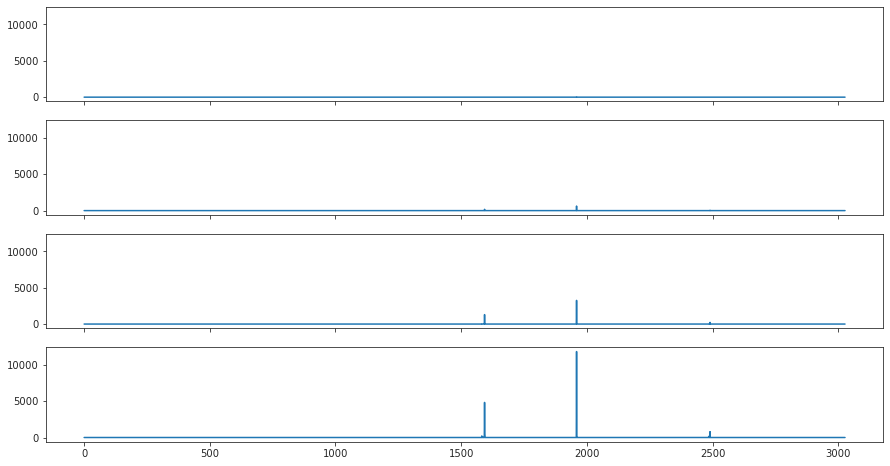

In [23]:
fig, axes = create_figure(4, 1, (15, 8), 'all', 'all')
for i, ax in enumerate(axes.flat):
    ax.plot(a[:, i])
    # ax.set_yscale('log')

In [27]:
ids = np.argsort(a[:, 3])[::-1]

In [29]:
a[ids][:10]

array([[4.70497303e+01, 6.24381454e+02, 3.25176420e+03, 1.18062537e+04],
       [6.09734440e+00, 1.76353558e+02, 1.29898698e+03, 4.81890981e+03],
       [4.28144193e+00, 4.32554083e+01, 2.24989483e+02, 8.07263673e+02],
       [2.16084993e+00, 1.57247159e+01, 9.92054600e+01, 4.63432818e+02],
       [1.19143877e-01, 3.40490681e+00, 3.50532925e+01, 2.12924517e+02],
       [3.73780169e-02, 1.79290777e+00, 2.68807427e+01, 1.75726674e+02],
       [7.94552900e-02, 8.66108224e-01, 7.59450638e+00, 4.32092611e+01],
       [2.84448471e-02, 5.04085064e-01, 5.93678675e+00, 3.94013906e+01],
       [3.92370038e-02, 2.42084436e-01, 1.97695330e+00, 1.15657066e+01],
       [4.41845823e-02, 4.34113048e-01, 2.57850293e+00, 1.09694010e+01]])